In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import RMSprop
import numpy as np
import random
import sys


In [5]:
#LOAD TEXT
#Save notepad as UTF-8 (select from dropdown during saving)
filename = "data/book.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()

print(raw_text[0:1000])

mowgli’s brothers

     now rann the kite brings home the night
        that mang the bat sets free--
     the herds are shut in byre and hut
        for loosed till dawn are we.
     this is the hour of pride and power,
        talon and tush and claw.
     oh, hear the call!--good hunting all
        that keep the jungle law!
     night-song in the jungle

it was seven o’clock of a very warm evening in the seeonee hills when
father wolf woke up from his day’s rest, scratched himself, yawned, and
spread out his paws one after the other to get rid of the sleepy feeling
in their tips. mother wolf lay with her big gray nose dropped across her
four tumbling, squealing cubs, and the moon shone into the mouth of the
cave where they all lived. “augrh!” said father wolf. “it is time to
hunt again.” he was going to spring down hill when a little shadow with
a bushy tail crossed the threshold and whined: “good luck go with you, o
chief of the wolves. and good luck and strong white teeth go with

In [6]:
#CLEAN TEXT
#Remove digits
raw_text = ''.join(c for c in raw_text if not c.isdigit())

In [7]:
#How many total characters do we have in our training text?
chars = sorted(list(set(raw_text))) #List of every character

char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))



In [8]:
# summarize the data
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters in the text; corpus length: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters in the text; corpus length:  291857
Total Vocab:  49


In [9]:
########################
#Now that we have characters we can create input/output sequences for training
#Remember that for LSTM input and output can be sequences... hence the term seq2seq


seq_length = 60  #Length of each input sequence
step = 10   #Instead of moving 1 letter at a time, try skipping a few. 
sentences = []    # X values (Sentences)
next_chars = []   # Y values. The character that follows the sentence defined as X
for i in range(0, n_chars - seq_length, step):  #step=1 means each sentence is offset just by a single letter
    sentences.append(raw_text[i: i + seq_length])  #Sequence in
    next_chars.append(raw_text[i + seq_length])  #Sequence out
n_patterns = len(sentences)    
print('Number of sequences:', n_patterns)

#Have a look at sentences and next_chars to see the continuity...
############################

Number of sequences: 29180


In [10]:
#Just like time series, X is the sequence / sentence and y is the next value
#that comes after the sentence... 

# reshape input to be [samples, time steps, features]

#time steps = sequence length
#features = numbers of characters in our vocab (n_vocab)
#Vectorize all sentences: there are n_patterns sentences.
#For each sentence we have n_vocab characters available for seq_length
#Vectorization returns a vector for all sentences indicating the presence or absence 
#of a character. 

x = np.zeros((len(sentences), seq_length, n_vocab), dtype=np.bool)
y = np.zeros((len(sentences), n_vocab), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_to_int[char]] = 1
    y[i, char_to_int[next_chars[i]]] = 1
    
print(x.shape)
print(y.shape)

print(y[0:10])

/var/folders/pk/zmnwmmlj6d16wn3l4ql40ym80000gn/T/ipykernel_99388/1466857379.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.zeros((len(sentences), seq_length, n_vocab), dtype=np.bool)
/var/folders/pk/zmnwmmlj6d16wn3l4ql40ym80000gn/T/ipykernel_99388/1466857379.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((len(sentenc

(29180, 60, 49)
(29180, 49)
[[False False False False False False False False False False False False
  False False False False False False False False False False False False
  False  True False False False False False False False False False False
  False False False False False False False False False False False False
  False]
 [False  True False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False]
 [False False False False False False False False False False False False
  False False False False False False False False False False False False
  False  True False False False False False False False False False False
  False False False False False False False False False False False False
  False]
 [False False False False False False False False False F

In [11]:
#Basic model with one LSTM
# build the model: a single LSTM

#model = Sequential()
#model.add(LSTM(128, input_shape=(seq_length, n_vocab)))
#model.add(Dense(n_vocab, activation='softmax'))
#
#optimizer = RMSprop(lr=0.01)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer)
#model.summary()


2022-10-25 11:37:10.564125: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               91136     
                                                                 
 dense (Dense)               (None, 49)                6321      
                                                                 
Total params: 97,457
Trainable params: 97,457
Non-trainable params: 0
_________________________________________________________________


/Users/nostest/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [24]:
# Deeper model woth 2 LSTM
#To stack LSTM layers, we need to change the configuration of the prior 
#LSTM layer to output a 3D array as input for the subsequent layer.
#We can do this by setting the return_sequences argument on the layer to True 
#(defaults to False). This will return one output for each input time step and provide a 3D array.
#Below is the same example as above with return_sequences=True.

model = Sequential()
model.add(LSTM(128, input_shape=(seq_length, n_vocab), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(n_vocab, activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 60, 128)           91136     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 49)                6321      
                                                                 
Total params: 229,041
Trainable params: 229,041
Non-trainable params: 0
_________________________________________________________________


/Users/nostest/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [25]:
# define the checkpoint
from keras.callbacks import ModelCheckpoint

filepath="saved_weights/saved_weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]


# Fit the model

history = model.fit(x, y,
          batch_size=128,
          epochs=50,   
          callbacks=callbacks_list)

model.save('my_saved_weights_jungle_book_50epochs.h5')

Epoch 1/50
228/228 [==============================] - ETA: 0s - loss: 2.7295
Epoch 1: loss improved from inf to 2.72948, saving model to saved_weights/saved_weights-01-2.7295.hdf5
228/228 [==============================] - 39s 160ms/step - loss: 2.7295
Epoch 2/50
228/228 [==============================] - ETA: 0s - loss: 2.1584
Epoch 2: loss improved from 2.72948 to 2.15836, saving model to saved_weights/saved_weights-02-2.1584.hdf5
228/228 [==============================] - 36s 158ms/step - loss: 2.1584
Epoch 3/50
228/228 [==============================] - ETA: 0s - loss: 1.9636
Epoch 3: loss improved from 2.15836 to 1.96359, saving model to saved_weights/saved_weights-03-1.9636.hdf5
228/228 [==============================] - 36s 159ms/step - loss: 1.9636
Epoch 4/50
228/228 [==============================] - ETA: 0s - loss: 1.8385
Epoch 4: loss improved from 1.96359 to 1.83855, saving model to saved_weights/saved_weights-04-1.8385.hdf5
228/228 [==============================] - 36s 15

228/228 [==============================] - 37s 161ms/step - loss: 1.0979
Epoch 33/50
228/228 [==============================] - ETA: 0s - loss: 1.1045
Epoch 33: loss did not improve from 1.09787
228/228 [==============================] - 36s 159ms/step - loss: 1.1045
Epoch 34/50
228/228 [==============================] - ETA: 0s - loss: 1.0848
Epoch 34: loss improved from 1.09787 to 1.08479, saving model to saved_weights/saved_weights-34-1.0848.hdf5
228/228 [==============================] - 36s 158ms/step - loss: 1.0848
Epoch 35/50
228/228 [==============================] - ETA: 0s - loss: 1.0788
Epoch 35: loss improved from 1.08479 to 1.07881, saving model to saved_weights/saved_weights-35-1.0788.hdf5
228/228 [==============================] - 37s 161ms/step - loss: 1.0788
Epoch 36/50
228/228 [==============================] - ETA: 0s - loss: 1.0703
Epoch 36: loss improved from 1.07881 to 1.07035, saving model to saved_weights/saved_weights-36-1.0703.hdf5
228/228 [===================

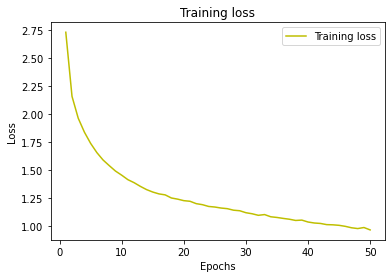

In [38]:
from matplotlib import pyplot as plt
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
#Generate characters 
#We must provide a sequence of seq_lenth as input to start the generation process

#The prediction results is probabilities for each of the 48 characters at a specific
#point in sequence. Let us pick the one with max probability and print it out.
#Writing our own softmax function....

def sample(preds):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds) #exp of log (x), isn't this same as x??
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1) 
    return np.argmax(probas)


In [40]:
#Prediction
# load the network weights
filename = "my_saved_weights_jungle_book_50epochs.h5"
model.load_weights(filename)


In [41]:
#Pick a random sentence from the text as seed.
start_index = random.randint(0, n_chars - seq_length - 1)

In [42]:
#Initiate generated text and keep adding new predictions and print them out
generated = ''
sentence = raw_text[start_index: start_index + seq_length]
generated += sentence

print('----- Seed for our text prediction: "' + sentence + '"')
#sys.stdout.write(generated)




----- Seed for our text prediction: "lia!
see you on parade to-morrow, i suppose. good-night, old"


In [43]:
for i in range(400):   # Number of characters including spaces
    x_pred = np.zeros((1, seq_length, n_vocab))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_to_int[char]] = 1.

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds)
    next_char = int_to_char[next_index]

    generated += next_char
    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
print()

 be his fame. “shou prose to be splay, 

/var/folders/pk/zmnwmmlj6d16wn3l4ql40ym80000gn/T/ipykernel_99388/3847965290.py:10: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds)


seal where there was a gras sence make.,
in a bun as not domp at lains, and when make he
thim? he his hut by the boster socenty shark!” take
i
     here he had been saubbing in the nug,
and the buffaloes, the buffaloes, and drupped his they get to snep, it was a farmse. “the man. what yer sure so but it man-under--if the sha suggeral of the jungle, of the moo
